# Linear Regression

This notebook implements linear regression, a supervised learning technique for predicting numerical values given a set of features. For details on the algorithm, check out the [`README`](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/linear_regression/README.md) in this subdirectory!

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import functions from scikit-learn to help with training/testing endeavors
from sklearn.model_selection import train_test_split

# Set the Seaborn theme
sns.set_theme()

## The Data

A linear regression model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

First, I read in the dataset into a pandas DataFrame object, and subset the DataFrame to observations containing no missing values for all the variables of interest. Afterwards, this full dataset will be randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. 
* This process is detailed in Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb), along with other information about the dataset.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Age", "Wing", "Weight", "Culmen", "Hallux", "Tail"]].dropna(axis=0)
hawks

,Species,Age,Wing,Weight,Culmen,Hallux,Tail
0,RT,I,385.0,920.0,25.7,30.1,219
2,RT,I,381.0,990.0,26.7,31.3,235
3,CH,I,265.0,470.0,18.7,23.5,220
4,SS,I,205.0,170.0,12.5,14.3,157
5,RT,I,412.0,1090.0,28.5,32.2,230
...,...,...,...,...,...,...,...
903,RT,I,380.0,1525.0,26.0,27.6,224
904,SS,I,190.0,175.0,12.7,15.4,150
905,RT,I,360.0,790.0,21.9,27.6,211
906,RT,I,369.0,860.0,25.2,28.0,207


## Training the model: a custom class

To implement linear regression, I create this custom class with all the necessary functionalities outlined by the algorithm, found in the `README.md` file of this `linear_regression` directory.

In [3]:
class MyLinearRegression:
    """
    A class to fit a linear regression model to data and obtain model diagnostics.

    ...

    Attributes
    ----------
    weights: numpy array (of floats)
        Parameters of the trained models, organized as [w_bias, w_1, w_2, ..., w_n]
    iterations: integer denoting the maximum number of iterations allowed during model training 
    train_errors: list of floats
        Each entry in this list is an error calculated during training iterations
    equation: a string that formats the weight of the model into a linear regression equation
    
    """
    
    def __init__(self):
        self.weights = None
        self.iterations = 0
        self.train_errors = []
        self.equation = ""
    
    def train(self, X, y, rate=0.05, iterations=1000):
        """
        Train a linear regression model

        Parameters
        ----------
        X: matrix of feature values
        y: array of observed values
        rate (float): learning rate
        iterations (int): number of iterations to train the model for

        Returns: None
        """
        self.iterations = iterations
        n_obs, n_features = X.shape

        # Initialize coefficients/weights and intercept/bias from a uniform distribution
        self.weights = np.random.rand(n_features + 1)
        
        # Implement stochastic gradient decent
        for _ in range(iterations):
            total_error = 0
            for i in range(0, n_obs):
                err = self.predict(X[i,]) - y[i]
                self.weights -= rate * err * np.insert(X[i,], 0, 1)
                total_error += 0.5 * err**2
            self.train_errors.append(total_error / n_obs)
        
        # Format a nice equation to print using the model weights
        self.set_equation()

    def set_equation(self):
        """
        Using the model weights, format a nice equation to print
        """
        eqn = f"y = {self.weights[0]:.3f}"
        for i in range(1, len(self.weights)):
            term = self.weights[i]
            if (np.sign(term) < 0):
                eqn += f" - {abs(term):.3f}x_{i}"
            else:
                eqn += f" + {term:.3f}x_{i}"
        self.equation = eqn

    def plot_train_errors(self):
        """
        Plot the MSE per iteration while the model was being trained
        """
        plt.figure(figsize = (8, 6))
        plt.plot(range(1, self.iterations + 1), self.train_errors)
        plt.xlabel("Iterations")
        plt.ylabel("Mean-squared error")
            
    def predict(self, X):
        """
        Obtain the predicted value given an array of features - not for bulk predictions

        Parameters
        ----------
        X: single numpy array of feature values

        Returns: numeric value predicted from the model
        """
        X = np.insert(X, 0, 1)
        return np.dot(X, self.weights)
    
    def calc_rss(self, y_true, y_pred):
        """
        A helpful function used to calculate the residual sum of squares component of the MSE and R^2

        Parameters
        ----------
        y_true: single numpy array of true response values
        y_pred: single numpy array of predictions from linear model
        
        Returns: numeric value denoting the residual sum for the input arrays
        """
        rss = 0
        for i in range(0, len(y_true)):
            rss += (y_true[i] - y_pred[i])**2
        return rss

    def mse(self, y_true, y_pred):
        """
        Calculate the mean squared error for a set of predicted and true values

        Parameters
        ----------
        y_true: single numpy array of true response values
        y_pred: single numpy array of predictions from linear model
        
        Returns: numeric value denoting the residual sum of squares for the input arrays
        """
        return self.calc_rss(y_true, y_pred) / len(y_true)
    
    def r_squared(self, y_true, y_pred):
        """
        Calculate the coefficient of determination for a set of predicted and true values

        Parameters
        ----------
        y_true: single numpy array of true response values
        y_pred: single numpy array of predictions from linear model
        
        Returns: numeric value denoting the coefficient of determination for the input arrays
        """
        rss = self.calc_rss(y_true, y_pred)
        sst = sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (rss / sst)


First, I test this class on some sample simulated data.

In [4]:
X = np.array([[1,2], [3,4], [5,6]])
y = np.array([7, 8, 9])

lin_model = MyLinearRegression()
lin_model.train(X, y, 0.01, 1000)

print(lin_model.weights) # prints the model parameters
print(lin_model.equation) # prints the model in equation form

[ 4.50624343 -1.49234121  1.99260429]
y = 4.506 - 1.492x_1 + 1.993x_2


## Model 1: Predicting Weight From Wing Length

As one sees from the scatterplot below, there appears to be a linear relationship between wing length and the weight of a hawk, although it arguably could be better. As wing length increases by 1 mm, there appears to be a linear increase in weight. Thus, a potential linear regression model would be to predict a hawk's weight from their wing length, and this is what will be modeled first.

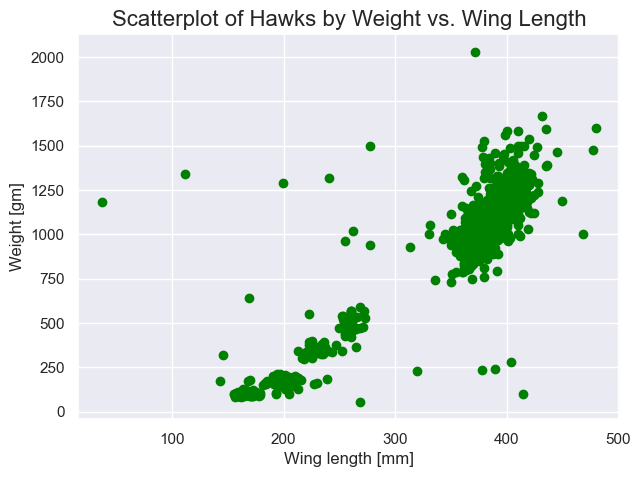

In [5]:
plt.figure(figsize = (7, 5))
plt.scatter(hawks.Wing, hawks.Weight, color = "green")
plt.title("Scatterplot of Hawks by Weight vs. Wing Length", fontsize = 16)
plt.xlabel("Wing length [mm]", fontsize = 12)
plt.ylabel("Weight [gm]", fontsize = 12)
plt.show()

### Splitting the data to train model 1

The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

In [6]:
# Set up predictors matrix (X) and response vector (y)
X = hawks[["Wing"]].to_numpy()
y = hawks["Weight"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

Now, I train a linear regression model for the Hawk data to predict tail length from wing length using the class defined previously.

The learning rate of `0.00001` was determined using trial and error. I started off with a learning rate of 0.01, but found that there would be overflow errors. The error calculated at each step of stochastic gradient descent would be too large, causing the weights to fail to converge. I added zeroes to the initial learning rate and increased the number of epochs/iterations until the current learning rate of `0.00001` and `5000` iterations produced satisfactory results.

In [7]:
weight_model = MyLinearRegression()
weight_model.train(X_train, y_train, 0.00001, 5000)

print(weight_model.weights) # prints the model parameters
print(weight_model.equation) # display the equation for the linear line

[-633.31718744    4.31763473]
y = -633.317 + 4.318x_1


The model tells us that an increase in wing length by 1 mm signifies an increase in hawk weight by 4.318 grams. Hypothetically, a hawk with a wing length of 0 mm would have a weight of -633.317 grams.

In the next block of code, I display a scatterplot of weight vs. wing length for both training and testing set, with this fitted linear regression line overlaid.

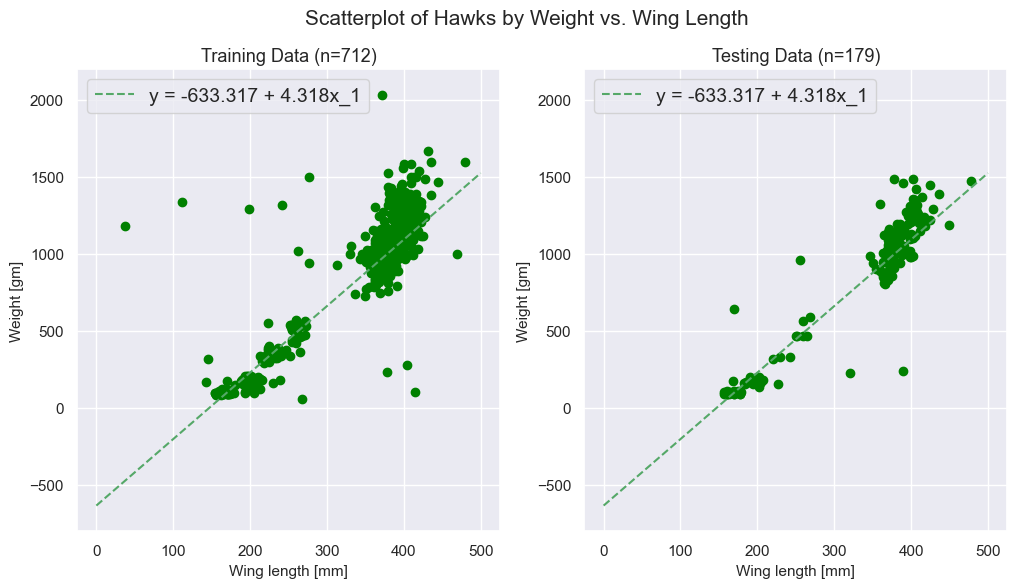

In [8]:
# Obtain the linear regression line
line_x = np.linspace(0, 500, 100)
line_y = weight_model.weights[0] + weight_model.weights[1]*line_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Scatterplot of Hawks by Weight vs. Wing Length", fontsize = 15)
# Plot the training set
ax1.set_ylim((-800, 2200))
ax1.scatter(X_train, y_train, color = "green")
ax1.set_xlabel("Wing length [mm]", fontsize = 11)
ax1.set_ylabel("Weight [gm]", fontsize = 11)
ax1.set_title("Training Data (n=712)", fontsize = 13)
ax1.plot(line_x, line_y, '--g', label = weight_model.equation)
ax1.legend(fontsize = 14, loc = "upper left")

# Plot the testing set
ax2.set_ylim((-800, 2200))
ax2.scatter(X_test, y_test, color = "green")
ax2.set_xlabel("Wing length [mm]", fontsize = 11)
ax2.set_ylabel("Weight [gm]", fontsize = 11)
ax2.set_title("Testing Data (n=179)", fontsize = 13)
ax2.plot(line_x, line_y, '--g', label = weight_model.equation)
ax2.legend(fontsize = 14, loc = "upper left")
plt.show()

The data follows the regression line closely for both the training and testing data!

### Performance/error analysis for model 1

Now, I will examine the performance of the model, in terms of training error and testing error.

In [9]:
# Obtain predictions for training set and find the error of the model
y_train_pred = [weight_model.predict(x) for x in X_train]
print(weight_model.mse(y_train, y_train_pred))

31353.9755445293


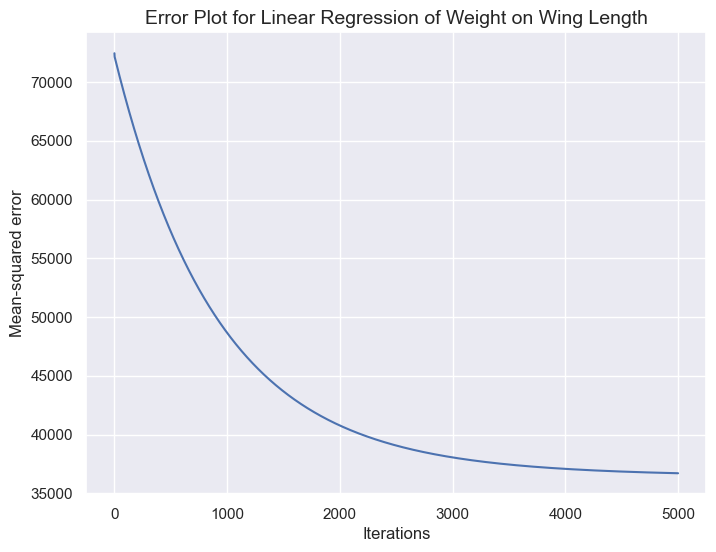

In [10]:
# Plot the model error over the course of training
weight_model.plot_train_errors()
plt.title("Error Plot for Linear Regression of Weight on Wing Length", fontsize = 14)
plt.show()

Another good metric to evaluate the performance of this linear regression model is the **coefficient of determination**, denoted $R^2$. Ranging from 0 (bad) to 1 (good), this statistic essentially measures how much the variability in the response can be explained by the regression model.

In [11]:
r2 = weight_model.r_squared(y_train, y_train_pred)
print(r2)

0.8518940223148911


This coefficient of determination is a large number, meaning that we have a good fit for the data!

Taking the square root of the coefficient of determination gives the **correlation coefficient**, denoted by r. Ranging from -1 to 1, larger magnitudes signify that there is a strong linear relationship between the predictor and response.

In [12]:
np.sqrt(r2)

0.9229810519804245

To no surprise considering the $R^2$, there is a strong linear relationship between a hawk's wing length and their weight.

#### Onto the testing set

In [13]:
# Obtain predictions for testing set and find the error of the model
y_test_pred = [weight_model.predict(x) for x in X_test]
print(weight_model.mse(y_test, y_test_pred))

20250.24975127962


The MSE for the testing set is lower than the training set, which is an interesting phenomenon. Generally, the training MSE should be lower, because the model is optimized under the training data. In practice, the model should be retrained, possibly with more/different data, but I will continue with my analysis.

In [14]:
r2 = weight_model.r_squared(y_test, y_test_pred)
print(r2)

0.9086654475006237


In [15]:
np.sqrt(r2)

0.9532394491944948

The high coefficient of determination and correlation coefficient for the testing set confirm that this is a good linear model for predicting a hawk's weight from wing length. Furthermore, we still have the strong linear relationship when running testing data through the model.

## Model 2: Predicting Weight from Wing, Tail, Hallux, and Culmen Length

Next, we will predict weight from multiple features instead of just the single wing length feature, and compare the performances.

In [16]:
# Set up predictors matrix (X) and response vector (y)
X2 = hawks[["Wing", "Tail", "Hallux", "Culmen"]].to_numpy()
y2 = hawks["Weight"].to_numpy()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=1)

In [17]:
weight_model2 = MyLinearRegression()
weight_model2.train(X_train2, y_train2, 0.00001, 5000)

print(weight_model2.weights) # prints the model parameters
print(weight_model2.equation) # display the equation for the linear line

[-3.98823488e+02  6.75016706e-01 -2.01009469e+00 -1.94557068e-01
  4.16313422e+01]
y = -398.823 + 0.675x_1 - 2.010x_2 - 0.195x_3 + 41.631x_4


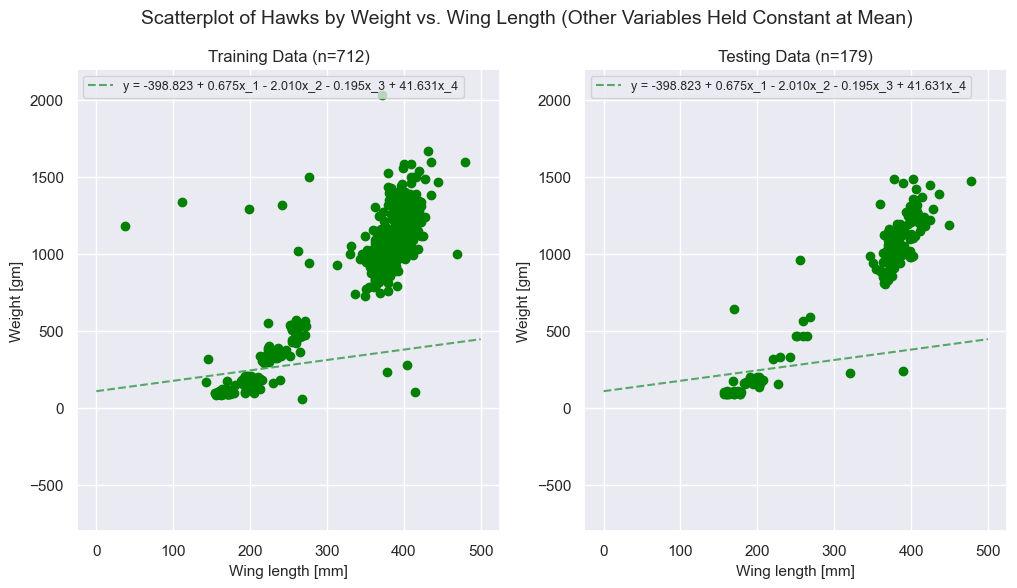

In [18]:
# Obtain the linear regression line
# allowing wing length to vary and keep other variables constant at their mean
line_y2 = weight_model2.weights[0] + weight_model2.weights[1]*line_x + weight_model2.weights[2]*np.mean(
     X_train2[:, 1]) +  weight_model2.weights[3]*np.mean(X_train2[:, 2]) + weight_model2.weights[4]*np.mean(X_train2[:, 3])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle(f"Scatterplot of Hawks by Weight vs. Wing Length (Other Variables Held Constant at Mean)", fontsize = 14)
# Plot the training set
ax1.set_ylim((-800, 2200))
ax1.scatter(X_train2[:, 0], y_train2, color = "green")
ax1.set_xlabel("Wing length [mm]", fontsize = 11)
ax1.set_ylabel("Weight [gm]", fontsize = 11)
ax1.set_title("Training Data (n=712)", fontsize = 12)
ax1.plot(line_x, line_y2, '--g', label = weight_model2.equation)
ax1.legend(fontsize = 9, loc = "upper left")

# Plot the testing set
ax2.set_ylim((-800, 2200))
ax2.scatter(X_test2[:, 0], y_test2, color = "green")
ax2.set_xlabel("Wing length [mm]", fontsize = 11)
ax2.set_ylabel("Weight [gm]", fontsize = 11)
ax2.set_title("Testing Data (n=179)", fontsize = 12)
ax2.plot(line_x, line_y2, '--g', label = weight_model2.equation)
ax2.legend(fontsize = 9, loc = "upper left")
plt.show()

This time, the regression line does not follow the data closely. This plot suggests that the fitted model may be poor for the given data. Considering how many features we inputted into the model, this is probably due to overfitting. Now, I will obtain metrics to confirm that this is indeed a poor model for the data.

### Performance/error analysis for model 2

Now, I will examine the performance of the model, in terms of training error and testing error. 

Because this is also a model predicting weight, I will perform comparisons to the simple linear regression of model 1 as well.

In [19]:
# Obtain predictions for training set and find the error of the model
y_train_pred2 = [weight_model2.predict(x) for x in X_train2]
print(weight_model2.mse(y_train2, y_train_pred2))

250039.03909681164


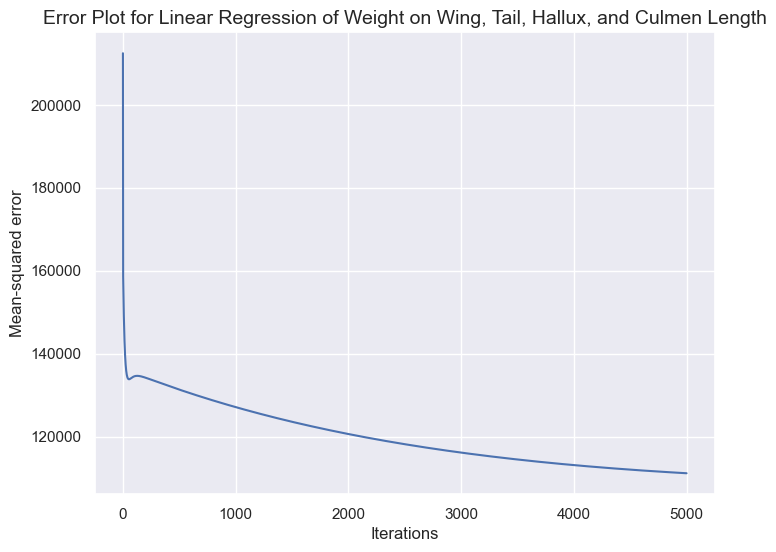

In [20]:
# Plot the model error over the course of training
weight_model2.plot_train_errors()
plt.title("Error Plot for Linear Regression of Weight on Wing, Tail, Hallux, and Culmen Length", fontsize = 14)
plt.show()

In [21]:
r2 = weight_model2.r_squared(y_train2, y_train_pred2)
print(r2)

-0.1811030563663214


The mean squared error for the training set is much higher in model 2 than in model 1. Furthermore, the coefficient of determination is negative, which means that the fitted linear model performs worse than an arbitrary horizontal line - which we noticed by viewing the scatterplot with linear line overlaid previously.

#### Onto the testing set

In [22]:
# Obtain predictions for training set and find the error of the model
y_test_pred2 = [weight_model2.predict(x) for x in X_test2]
print(weight_model2.mse(y_test2, y_test_pred2))

234244.52441408136


In [23]:
r2 = weight_model2.r_squared(y_test2, y_test_pred2)
print(r2)

-0.0565113554432779


These results are similar to those from the training set - model 2 is a poor fit for both training and testing data.

### Comparing model 1 vs. model 2

Based on the performance and error analysis for both models, it is clear that model 1 outshines model 2. 

Firstly, model 1 has the lower mean squared error by a factor of 8. In addition, it has the better fit for both training and testing data. Model 1 has a high coefficient of determination and subsequently correlation coefficient. On the other hand, model 2 has a negative coefficient of determination, which means that the fitted linear model performs worse than an arbitrary horizontal line - which we can observe by viewing the scatterplot with linear line overlaid.

Furthermore, model 1 only has 1 predictor, while model 2 has 4. Given the better performance and lower complexity of model 1, I would much rather use model 1 to predict a hawk's weight.

## Model 3: Linear Regressions for Weight on Wing Length by Species

For fun, I run the linear regression algorithm for each of the three hawk species. The plot below suggests that the linear relationship between wing length and weight for a hawk may vary depending on the species. For instance, the blue cluster (sharp-shinned hawk) has a flatter slope than the red cluster (red-tailed hawk). I'm curious whether there will be any different results in terms of slope, so now I will be training a linear regression model for each species to understand the liinear relationships at play.

I will be using the most simple single predictor model because as previously discussed, it has much better performance while being less complex.

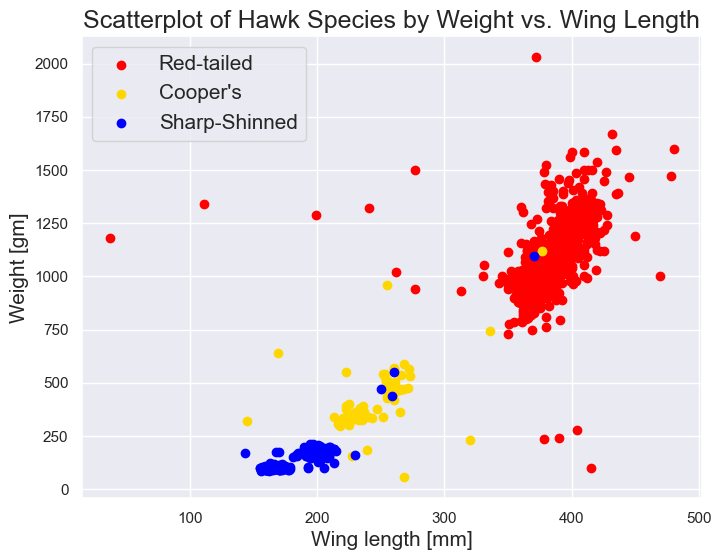

In [24]:
# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
RT = hawks[hawks.Species == "RT"]
CH = hawks[hawks.Species == "CH"]
SS = hawks[hawks.Species == "SS"]

plt.figure(figsize = (8, 6))
plt.scatter(RT.Wing, RT.Weight, color = "red", label = "Red-tailed")
plt.scatter(CH.Wing, CH.Weight, color = "gold", label = "Cooper's")
plt.scatter(SS.Wing, SS.Weight, color = "blue", label = "Sharp-Shinned")
plt.title("Scatterplot of Hawk Species by Weight vs. Wing Length", fontsize = 18)
plt.xlabel("Wing length [mm]", fontsize = 15)
plt.ylabel("Weight [gm]", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.show()

While the correct practice would be to split each species' subset into a training and testing set to train and evaluate the resulting model, the above analysis for model 1 and 2 suggests that the estimated regression line reflects the linear trend in both training and testing set. To keep things succinct, I will just train a model on all the observations for a given species, and evaluate the training error and model weights.

In [25]:
weight_model_RT = MyLinearRegression()
weight_model_RT.train(np.array(RT.Wing).reshape(-1, 1), np.array(RT.Weight), 0.00001, 5000)

weight_model_CH = MyLinearRegression()
weight_model_CH.train(np.array(CH.Wing).reshape(-1, 1), np.array(CH.Weight), 0.00001, 5000)

weight_model_SS = MyLinearRegression()
weight_model_SS.train(np.array(SS.Wing).reshape(-1, 1), np.array(SS.Weight), 0.00001, 5000)

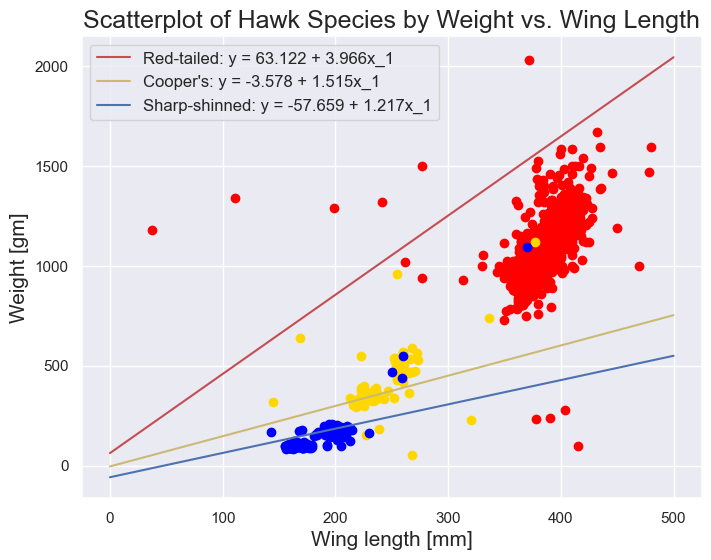

In [26]:
plt.figure(figsize = (8, 6))
plt.scatter(RT.Wing, RT.Weight, color = "red")
plt.scatter(CH.Wing, CH.Weight, color = "gold")
plt.scatter(SS.Wing, SS.Weight, color = "blue")
plt.title("Scatterplot of Hawk Species by Weight vs. Wing Length", fontsize = 18)
plt.xlabel("Wing length [mm]", fontsize = 15)
plt.ylabel("Weight [gm]", fontsize = 15)

x = np.linspace(0,500,100)
#y = tail_model.weights[0] + tail_model.weights[1]*x
plt.plot(x, weight_model_RT.weights[0] + weight_model_RT.weights[1]*x, '-r', label = f"Red-tailed: {weight_model_RT.equation}")
plt.plot(x, weight_model_CH.weights[0] + weight_model_CH.weights[1]*x, '-y', label = f"Cooper's: {weight_model_CH.equation}")
plt.plot(x, weight_model_SS.weights[0] + weight_model_SS.weights[1]*x, '-b', label = f"Sharp-shinned: {weight_model_SS.equation}")
plt.legend(fontsize = 12, loc = "upper left")
plt.show()

The line for red-tailed hawks has a much steeper slope than that of the other species, meaning an increase in wing length by 1 mm results in a larger linear increase in weight for red-tailed hawks.

However, is this truly the case?

### Performance/error analysis for model 3

First, the mean squared errors.

In [27]:
# Obtain predicted values
RT_predict = [weight_model_RT.predict(x) for x in np.array(RT.Wing).reshape(-1, 1)]
CH_predict = [weight_model_CH.predict(x) for x in np.array(CH.Wing).reshape(-1, 1)]
SS_predict = [weight_model_SS.predict(x) for x in np.array(SS.Wing).reshape(-1, 1)]

print("RT:", weight_model_RT.mse(np.array(RT.Weight), RT_predict))
print("CH:", weight_model_RT.mse(np.array(CH.Weight), CH_predict))
print("SS:", weight_model_RT.mse(np.array(SS.Weight), SS_predict))

RT: 275253.61619974684
CH: 22802.503687556287
SS: 3803.719918646188


The MSE is very high for the red-tailed hawks and lowest for the sharp-shinned hawks. Observing the spread in the data points for these three species, this is probably due to their different variances. It is harder to fit a linear line for the red-tailed hawks; in fact, the linear line for the red-tailed hawks has been pulled upwards by some observations with low wing length but high weight.

In [28]:
print("RT:", weight_model_RT.r_squared(np.array(RT.Weight), RT_predict))
print("CH:", weight_model_RT.r_squared(np.array(CH.Weight), CH_predict))
print("SS:", weight_model_RT.r_squared(np.array(SS.Weight), SS_predict))

RT: -6.6627926350323285
CH: 0.12974773756549618
SS: 0.41443350390205946


The $R^2$ values confirm that the linear fits for a singular species does not fare well. 

I could conclude that the linear relationship between wing length and weight do vary on species, considering how based on the coefficient of determination (and thus the correlation coefficient) there is a moderate linear relationship (r = 0.64) between the two variables for the sharp-shinned hawks and a weaker linear relationship for the Cooper's hawks (r = 0.35). For the red-tailed hawks, the linear fit does worse than a horizontal line, but this may be due to the observations pulling the slope of the line away from the main trend, as discussed previously.

One note is that in practice, you could formulate a single regression line that adjusts weights based on species. This would involve the usage of indicator variables. For the purposes of this fun exercise, I am keeping things simple.

# Using scikit-learn

Now, I will briefly set up how you would create a linear regression model using scikit-learn. The methods are much more efficient than the class I wrote considering computation time, but nevertheless creating the `MyLinearRegression` class allowed for understanding of the inner workings of the algorithm compared to using the blackbox function. Furthermore, my class has more functionalities compared to the scikit-learn class according to their [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [29]:
from sklearn.linear_model import LinearRegression

sk_reg = LinearRegression()
sk_reg.fit(X_train, y_train)
sk_reg.intercept_, sk_reg.coef_

(-654.7463120813271, array([4.52180775]))

Recall the results of model 1 trained using `MyLinearRegression` class.

In [30]:
print(weight_model.weights)
print(weight_model.equation)

[-633.31718744    4.31763473]
y = -633.317 + 4.318x_1


While there is a difference, the weights are fairly similar.

The coefficients produced from scikit-learn are comparable to those weights outputted from the trained model!

In [31]:
# Coefficient of determination for training set
sk_reg.score(X_train, y_train)

0.8625515057537385

In [32]:
# Coefficient of determination for testing set
sk_reg.score(X_test, y_test)

0.9154325887405701

The model is a good fit based on the high coefficient of determination, as I concluded in my analysis for model 1.

In [33]:
# Predict a hawk's weight given their wing length is 250 mm
sk_reg.predict(np.array([250]).reshape(-1, 1))

array([475.7056246])